# Infrastructure Analysis for Caribbean Cities

This notebook demonstrates how to download, process, and visualize infrastructure data from OpenStreetMap for Caribbean cities. The analysis categorizes infrastructure into four main types:

### Infrastructure Categories

1. **Critical Infrastructure** (Red): Government buildings, banks, utilities, airports, fuel stations
2. **Basic Social Services** (Blue): Hospitals, schools, police stations, fire stations  
3. **Mobility Networks** (Green): Streets, transportation hubs, parking facilities
4. **Buildings** (Orange): General buildings and structures

### Key Features

- **Data Download**: Automatic retrieval from OpenStreetMap using OSMnx
- **Smart Categorization**: Rule-based classification using multiple attributes
- **Interactive Visualization**: Customizable zoom and area focus
- **Data Export**: High-quality GeoPackage format for GIS applications

### Requirements

The notebook requires the following Python libraries:
- `osmnx`: OpenStreetMap data download and processing
- `geopandas`: Geospatial data handling
- `matplotlib`: Basic plotting and visualization  
- `contextily`: Basemap integration
- `cartopy`: Coordinate reference systems

In [1]:
# Infrastructure Analysis for Caribbean Cities
# OpenStreetMap Data Retrieval and Visualization

# Import required libraries
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import contextily as ctx
import os
from pyproj import datadir

# Set projection data directory
datadir.set_data_dir("/home/jupyter-daniela/.conda/envs/peru_environment/share/proj")

/home/jupyter-daniela/.conda/envs/peru_environment/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [ ]:
def get_buildings(place):
    """
    Download building data from OpenStreetMap for a given place.
    
    Parameters:
    -----------
    place : str
        Name of the place to download buildings from (e.g., "Castries, Saint Lucia")
    
    Returns:
    --------
    geopandas.GeoDataFrame
        GeoDataFrame containing building geometries and attributes
    
    Notes:
    ------
    The function filters for useful columns including building types, names, 
    addresses, and various amenity/service types.
    """
    tags = {"building": True}
    gdf = ox.features.features_from_place(place, tags)
    
    useful_cols = ["building", "name", "addr:city", "geometry"]
    extra_cols = ["amenity", "shop", "office", "tourism", "healthcare", "education", 
                  "religion", "sport", "leisure", "public_transport", "building:use"]
    
    for col in extra_cols:
        if col in gdf.columns:
            useful_cols.append(col)
    
    return gdf[[col for col in useful_cols if col in gdf.columns]]

def get_streets(place_polygon):
    """
    Download street network data from OpenStreetMap for a given polygon.
    
    Parameters:
    -----------
    place_polygon : shapely.geometry
        Polygon geometry defining the area of interest
    
    Returns:
    --------
    geopandas.GeoDataFrame
        GeoDataFrame containing street network geometries and attributes
    
    Notes:
    ------
    Uses the drive network type to get all drivable roads and converts
    list-type columns to string format for better compatibility.
    """
    graph = ox.graph_from_polygon(place_polygon, network_type="drive", retain_all=True)
    gdf_streets = ox.graph_to_gdfs(graph, nodes=False)
    
    for column in gdf_streets.columns:
        gdf_streets[column] = gdf_streets[column].apply(
            lambda x: ", ".join(map(str, x)) if isinstance(x, list) else x
        )
    
    return gdf_streets

def recategorize_buildings(gdf):
    """
    Categorize buildings into infrastructure types based on their attributes.
    
    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame containing building data from OpenStreetMap
    
    Returns:
    --------
    geopandas.GeoDataFrame
        GeoDataFrame with added 'main_category' column containing:
        - '1_Critical_Infrastructure': Essential services (government, banks, utilities)
        - '2_Basic_Social_Services': Health, education, emergency services
        - '3_Mobility_Networks': Transportation hubs and facilities
        - '4_Buildings': General buildings and structures
    
    Notes:
    ------
    The categorization is based on:
    1. OSM amenity tags
    2. Building type classifications
    3. Name-based keyword matching
    4. Specific building use attributes
    """
    df = gdf.copy()
    df['main_category'] = '4_Buildings'  # Default category
    
    if 'amenity' in df.columns:
        critical_amenities = ['airport', 'aerodrome', 'heliport', 'terminal', 'fuel', 'charging_station',
                            'post_office', 'embassy', 'townhall', 'government', 'bank', 'atm']
        df.loc[df['amenity'].isin(critical_amenities), 'main_category'] = '1_Critical_Infrastructure'
        
        social_amenities = ['hospital', 'clinic', 'pharmacy', 'doctors', 'school', 'university', 
                          'college', 'kindergarten', 'police', 'fire_station']
        df.loc[df['amenity'].isin(social_amenities), 'main_category'] = '2_Basic_Social_Services'
        
        mobility_amenities = ['bus_station', 'train_station', 'parking', 'parking_entrance']
        df.loc[df['amenity'].isin(mobility_amenities), 'main_category'] = '3_Mobility_Networks'
    
    def categorize_by_name(row):
        """Helper function to categorize buildings based on name and other attributes."""
        if row['building'] != 'yes':
            return row['main_category']
        
        for col in ['shop', 'office', 'tourism', 'healthcare', 'education']:
            if col in row.index and pd.notna(row[col]):
                col_value = str(row[col]).lower()
                
                if col == 'office' and any(word in col_value for word in ['government', 'administrative', 'bank', 'financial']):
                    return '1_Critical_Infrastructure'
                elif col == 'healthcare' or (col == 'shop' and 'pharmacy' in col_value):
                    return '2_Basic_Social_Services'
                elif col == 'education':
                    return '2_Basic_Social_Services'
        
        if pd.notna(row['name']):
            name_lower = str(row['name']).lower()
            
            critical_words = ['embassy', 'ministry', 'government', 'administrative', 'municipal', 
                             'city hall', 'town hall', 'courthouse', 'bank', 'central bank', 'financial', 
                             'treasury', 'airport', 'airfield', 'heliport', 'aviation', 'gas station', 
                             'fuel', 'charging station', 'power plant', 'utility']
            
            social_words = ['hospital', 'clinic', 'pharmacy', 'medical', 'health center', 'dispensary',
                           'school', 'university', 'college', 'academy', 'institute', 'kindergarten', 
                           'nursery', 'police', 'fire station', 'emergency', 'rescue']
            
            mobility_words = ['airport', 'terminal', 'bus station', 'train station', 'transport', 
                             'port', 'harbor', 'highway', 'bridge', 'tunnel']
            
            if any(word in name_lower for word in critical_words):
                return '1_Critical_Infrastructure'
            elif any(word in name_lower for word in social_words):
                return '2_Basic_Social_Services'
            elif any(word in name_lower for word in mobility_words):
                return '3_Mobility_Networks'
        
        return row['main_category']
    
    df['main_category'] = df.apply(categorize_by_name, axis=1)
    
    building_type_map = {
        'government': '1_Critical_Infrastructure', 'embassy': '1_Critical_Infrastructure', 
        'terminal': '1_Critical_Infrastructure', 'hospital': '2_Basic_Social_Services',
        'clinic': '2_Basic_Social_Services', 'school': '2_Basic_Social_Services',
        'university': '2_Basic_Social_Services', 'police': '2_Basic_Social_Services',
        'airport': '3_Mobility_Networks', 'train_station': '3_Mobility_Networks'
    }
    
    for building_type, category in building_type_map.items():
        df.loc[df['building'] == building_type, 'main_category'] = category
    
    df = df[~((df['building'] == 'yes') & 
              (pd.isna(df['name'])) & 
              (df['main_category'] == '4_Buildings'))]
    
    return df

In [3]:
# List of Caribbean cities to analyze
cities = [
    "Kingston, Jamaica",
    "Port of Spain, Trinidad and Tobago", 
    "Bridgetown, Barbados",
    "Santo Domingo, Dominican Republic",
    "Castries, Saint Lucia"
]

In [ ]:
# Main data processing: Download and categorize infrastructure data
place_name = "Castries, Saint Lucia"

print("Downloading building data...")
buildings = get_buildings(place_name)

print("Downloading street network data...")
place_polygon = ox.geocode_to_gdf(place_name)
streets = get_streets(place_polygon.geometry.iloc[0])

print("Categorizing buildings...")
buildings_categorized = recategorize_buildings(buildings)

buildings_categorized['type'] = 'building'
streets['main_category'] = '3_Mobility_Networks'
streets['type'] = 'street'

all_infrastructure = pd.concat([
    buildings_categorized[['geometry', 'main_category', 'type']],
    streets[['geometry', 'main_category', 'type']]
], ignore_index=True)

infrastructure_gdf = gpd.GeoDataFrame(all_infrastructure, crs='EPSG:4326')

print(f"\nData processing completed!")
print(f"Total infrastructure elements: {len(all_infrastructure):,}")
print("\nDistribution by category:")
print(all_infrastructure['main_category'].value_counts().sort_index())

original_bounds = infrastructure_gdf.total_bounds
print(f"\nOriginal data bounds (lat/lon): {original_bounds}")
print("Format: [min_lon, min_lat, max_lon, max_lat]")

Categorizing buildings...
Categorizing buildings...

Data processing completed!
Total infrastructure elements: 7,261

Distribution by category:
main_category
1_Critical_Infrastructure      45
2_Basic_Social_Services       126
3_Mobility_Networks          3401
4_Buildings                  3689
Name: count, dtype: int64

Original data bounds (lat/lon): [-61.0313473  13.9011237 -60.9382967  14.0351   ]
Format: [min_lon, min_lat, max_lon, max_lat]

Data processing completed!
Total infrastructure elements: 7,261

Distribution by category:
main_category
1_Critical_Infrastructure      45
2_Basic_Social_Services       126
3_Mobility_Networks          3401
4_Buildings                  3689
Name: count, dtype: int64

Original data bounds (lat/lon): [-61.0313473  13.9011237 -60.9382967  14.0351   ]
Format: [min_lon, min_lat, max_lon, max_lat]


### Plot results

This step can be avoided

In [ ]:
def plot_infrastructure_with_zoom(infrastructure_gdf, zoom_factor=1.0, center_lat=None, center_lon=None, 
                                 bbox=None, figsize=(15, 12)):
    """
    Create an infrastructure map with customizable zoom functionality.
    
    Parameters:
    -----------
    infrastructure_gdf : geopandas.GeoDataFrame
        GeoDataFrame containing infrastructure data with 'main_category' column
    zoom_factor : float, default 1.0
        Zoom level (1.0 = normal, <1.0 = zoom out, >1.0 = zoom in)
    center_lat : float, optional
        Latitude coordinate for zoom center
    center_lon : float, optional  
        Longitude coordinate for zoom center
    bbox : tuple, optional
        Bounding box as (min_lon, min_lat, max_lon, max_lat) for specific area focus
    figsize : tuple, default (15, 12)
        Figure size as (width, height) in inches
    
    Returns:
    --------
    None
        Displays the map and prints current bounds information
    
    Notes:
    ------
    The map uses different colors and styles for each infrastructure category:
    - Critical Infrastructure: Red points
    - Basic Social Services: Blue points  
    - Mobility Networks: Green lines
    - Buildings: Orange points
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    infrastructure_web = infrastructure_gdf.to_crs(epsg=3857)
    
    colors = {
        '1_Critical_Infrastructure': '#e31a1c',    # Red
        '2_Basic_Social_Services': '#1f78b4',     # Blue
        '3_Mobility_Networks': '#33a02c',         # Green
        '4_Buildings': '#ff7f00'                  # Orange
    }
    
    for category in infrastructure_web['main_category'].unique():
        category_data = infrastructure_web[infrastructure_web['main_category'] == category]
        
        if category == '3_Mobility_Networks':
            category_data.plot(ax=ax, color=colors[category], linewidth=0.8, alpha=0.8)
        else:
            category_data.plot(ax=ax, color=colors[category], markersize=8, alpha=0.7)
    
    if bbox is not None:
        min_lon, min_lat, max_lon, max_lat = bbox
        from pyproj import Transformer
        transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
        min_x, min_y = transformer.transform(min_lon, min_lat)
        max_x, max_y = transformer.transform(max_lon, max_lat)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
    else:
        bounds = infrastructure_web.total_bounds
        min_x, min_y, max_x, max_y = bounds
        
        if center_lat is not None and center_lon is not None:
            from pyproj import Transformer
            transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
            center_x, center_y = transformer.transform(center_lon, center_lat)
        else:
            center_x = (min_x + max_x) / 2
            center_y = (min_y + max_y) / 2
        
        width = (max_x - min_x) / zoom_factor
        height = (max_y - min_y) / zoom_factor
        
        new_min_x = center_x - width / 2
        new_max_x = center_x + width / 2
        new_min_y = center_y - height / 2
        new_max_y = center_y + height / 2
        
        ax.set_xlim(new_min_x, new_max_x)
        ax.set_ylim(new_min_y, new_max_y)
    
    ctx.add_basemap(ax, crs=infrastructure_web.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.3)
    
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    legend_elements = []
    for category in sorted(infrastructure_web['main_category'].unique()):
        if category == '3_Mobility_Networks':
            legend_elements.append(Line2D([0], [0], color=colors[category], lw=2, 
                                        label=category.replace('_', ' ')))
        else:
            legend_elements.append(Patch(facecolor=colors[category], 
                                       label=category.replace('_', ' ')))
    
    ax.set_title('Infrastructure Analysis - Castries, Saint Lucia\nwith OpenStreetMap Background', 
                 fontsize=10, pad=20)
    ax.legend(handles=legend_elements, loc='upper left', frameon=False)
    ax.set_axis_off()
    
    plt.show()
    
    current_bounds = ax.get_xlim() + ax.get_ylim()
    print(f"Current map bounds (Web Mercator): {current_bounds}")

def export_to_geopackage(gdf, filename="infrastructure_data.gpkg", folder="outputs"):
    """
    Export GeoDataFrame to GeoPackage format.
    
    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame to export
    filename : str, default "infrastructure_data.gpkg"
        Output filename
    folder : str, default "outputs"
        Output folder path
    
    Returns:
    --------
    str
        Path to the exported file
    
    Notes:
    ------
    GeoPackage (.gpkg) is recommended for:
    - Better performance and compression
    - Complete geometry type support
    - Compatibility with QGIS, ArcGIS, Python, R
    - Preservation of all metadata and CRS information
    """
    output_path = os.path.join(folder, filename)
    
    print(f"Exporting infrastructure data to GeoPackage...")
    gdf.to_file(output_path, driver="GPKG")
    
    print("Export completed!")
    print(f"\nExported file information:")
    print(f"   File: {output_path}")
    print(f"   Total elements: {len(gdf):,}")
    print(f"   Columns: {list(gdf.columns)}")
    print(f"   CRS: {gdf.crs}")
    
    # Show file size
    if os.path.exists(output_path):
        size_mb = os.path.getsize(output_path) / (1024 * 1024)
        print(f"   Size: {size_mb:.2f} MB")
        print(f"   Full path: {os.path.abspath(output_path)}")
    
    return output_path

=== Example 1: Complete view ===


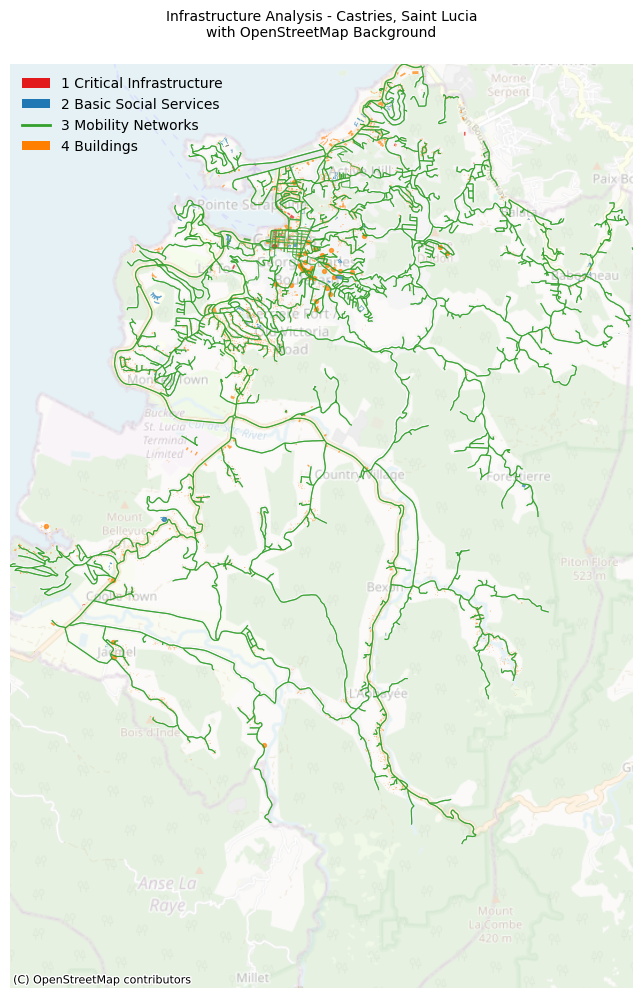

Current map bounds (Web Mercator): (np.float64(-6793978.5038634315), np.float64(-6783620.1584534235), np.float64(1562875.1630037907), np.float64(1578243.7871766747))


In [6]:
# Example 1: Complete view with normal zoom
print("=== Example 1: Complete view ===")
plot_infrastructure_with_zoom(infrastructure_gdf, zoom_factor=1.0)

=== Example 2: Central area focus ===


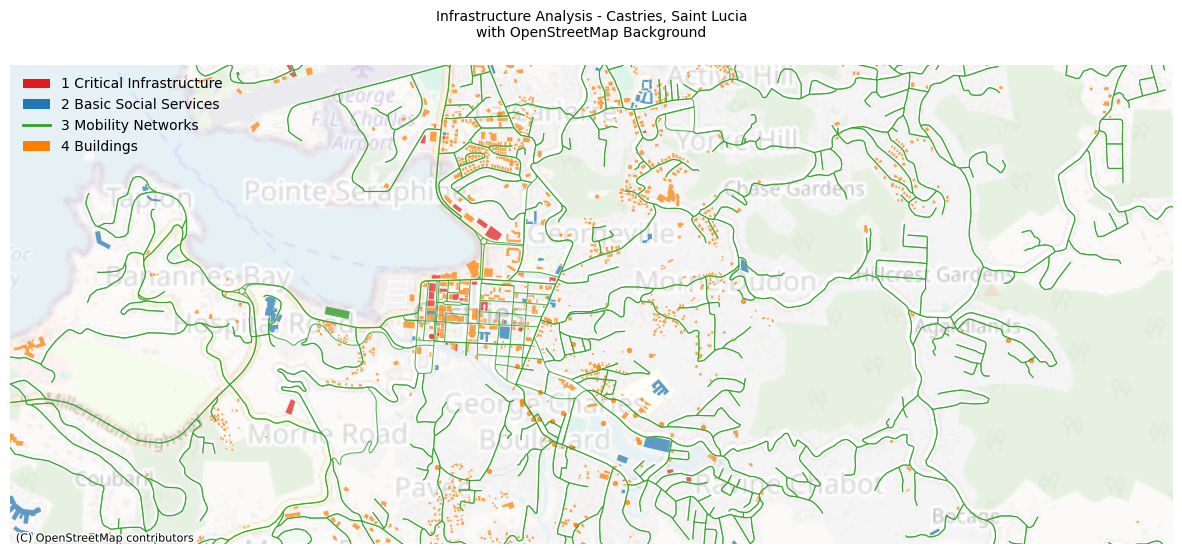

Current map bounds (Web Mercator): (np.float64(-6791602.13329762), np.float64(-6786036.158757957), np.float64(1574216.548161465), np.float64(1576511.1957517504))


In [7]:
# Example 2: Focus on central area using bounding box
print("=== Example 2: Central area focus ===")

# Define central area of Castries (adjust coordinates as needed)
central_bbox = (-61.01, 14.0, -60.96, 14.02)  # (min_lon, min_lat, max_lon, max_lat)
plot_infrastructure_with_zoom(infrastructure_gdf, bbox=central_bbox)

=== Example 3: Zoom in (3x closer) ===


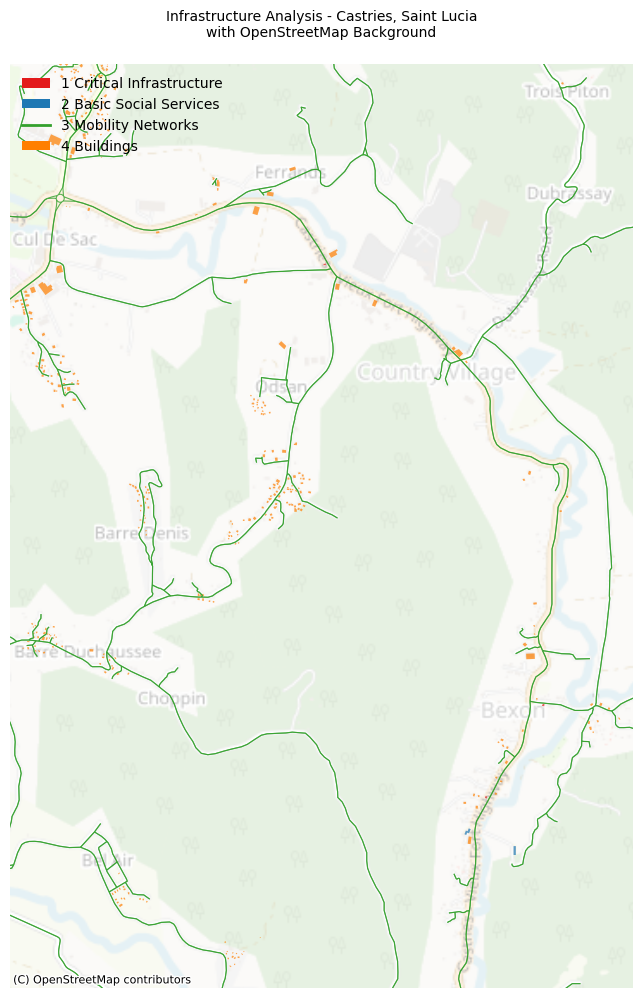

Current map bounds (Web Mercator): (np.float64(-6790525.7220600955), np.float64(-6787072.9402567595), np.float64(1567998.0377280852), np.float64(1573120.9124523802))


In [8]:
# Example 3: Zoom in with 3x magnification
print("=== Example 3: Zoom in (3x closer) ===")
plot_infrastructure_with_zoom(infrastructure_gdf, zoom_factor=3.0)

=== Example 4: Custom center with zoom ===


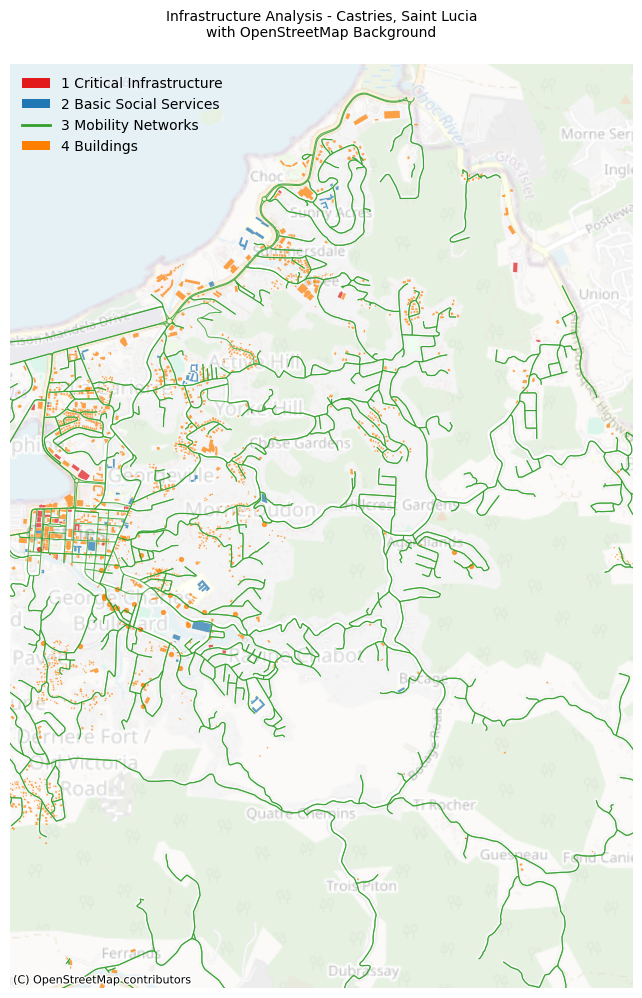

Current map bounds (Web Mercator): (np.float64(-6789777.620201858), np.float64(-6785634.282037854), np.float64(1572290.1221400287), np.float64(1578437.5718091826))


In [9]:
# Example 4: Center on specific coordinates with zoom
print("=== Example 4: Custom center with zoom ===")

# Center coordinates for Castries (approximate city center)
center_lat, center_lon = 14.010, -60.975
plot_infrastructure_with_zoom(infrastructure_gdf, 
                             zoom_factor=2.5, 
                             center_lat=center_lat, 
                             center_lon=center_lon)

In [10]:
# Export data to GeoPackage format
output_file = export_to_geopackage(infrastructure_gdf, 
                                  filename="castries_infrastructure.gpkg", 
                                  folder="outputs")

print("\nWhy GeoPackage is the best format:")
print("   - Better performance and compression")
print("   - Complete support for all geometry types")
print("   - Compatible with QGIS, ArcGIS, Python, R")
print("   - Maintains all metadata and CRS information")

Exporting infrastructure data to GeoPackage...
Export completed!

Exported file information:
   File: outputs/castries_infrastructure.gpkg
   Total elements: 7,261
   Columns: ['geometry', 'main_category', 'type']
   CRS: EPSG:4326
   Size: 1.95 MB
   Full path: /home/jupyter-daniela/osm_data_retrieval/outputs/castries_infrastructure.gpkg

Why GeoPackage is the best format:
   - Better performance and compression
   - Complete support for all geometry types
   - Compatible with QGIS, ArcGIS, Python, R
   - Maintains all metadata and CRS information
Export completed!

Exported file information:
   File: outputs/castries_infrastructure.gpkg
   Total elements: 7,261
   Columns: ['geometry', 'main_category', 'type']
   CRS: EPSG:4326
   Size: 1.95 MB
   Full path: /home/jupyter-daniela/osm_data_retrieval/outputs/castries_infrastructure.gpkg

Why GeoPackage is the best format:
   - Better performance and compression
   - Complete support for all geometry types
   - Compatible with QGIS, Arc